In [1]:
import pandas as pd
import numpy as np
import joblib as jb
from scipy.stats import spearmanr
%matplotlib inline

In [2]:
train_train_level0 = jb.load("train_train_level0.pkl.z")
train_train_level1 = jb.load("train_train_level1.pkl.z")
train_valid_level1 = jb.load("train_valid_level1.pkl.z")
test = pd.read_feather("test.f")


X_train0, y_train0 = train_train_level0.filter(regex=r'feature', axis=1), train_train_level0['target_kazutsugi']
X_train1, y_train1 = train_train_level1.filter(regex=r'feature', axis=1), train_train_level1['target_kazutsugi']
X_val1, y_val1 = train_valid_level1.filter(regex=r'feature', axis=1), train_valid_level1['target_kazutsugi']
X_test = test.filter(regex=r'feature', axis=1)

# Feature Rows

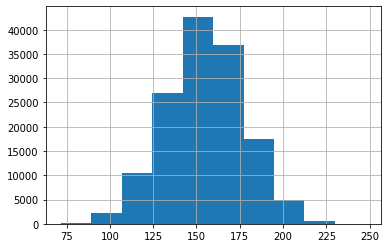

In [17]:
X_train0.sum(axis=1).hist()

In [33]:
#%%time
from xgboost import XGBRegressor

#iterar por colunas de grupos se tivesse mais categoricas

buckets_Xtr0 = np.digitize(X_train0.sum(axis=1), bins=[125,150,175])
buckets_Xtr1 = np.digitize(X_train1.sum(axis=1), bins=[125,150,175])
buckets_Xvl1 = np.digitize(X_val1.sum(axis=1), bins=[125,150,175])
buckets_Xts = np.digitize(X_test.sum(axis=1), bins=[125,150,175])


p_tr1 = np.zeros(X_train1.shape[0])
p_vl1 = np.zeros(X_val1.shape[0])
p_ts = np.zeros(X_test.shape[0])

for bucket in np.unique(buckets_Xtr0):
    
    Xtr0 = X_train0[buckets_Xtr0 == bucket]
    ytr0 = y_train0[buckets_Xtr0 == bucket]
    
    mdl = XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, colsample_bytree=0.1, tree_method='gpu_hist', gpu_id=0)
    mdl.fit(Xtr0, ytr0)
    
    Xtr1 = X_train1[buckets_Xtr1 == bucket]
    p_tr1[buckets_Xtr1 == bucket] = mdl.predict(Xtr1)
    
    Xvl1 = X_val1[buckets_Xvl1 == bucket]
    p_vl1[buckets_Xvl1 == bucket] = mdl.predict(Xvl1)
    
    Xts = X_test[buckets_Xts == bucket]
    p_ts[buckets_Xts == bucket] = mdl.predict(Xts)

    
model_name_train1 = "./preds_train1/xgb_row_groups_buckets.pkl.z"
jb.dump(p_tr1, model_name_train1)

metric = spearmanr(y_train1.values,p_tr1).correlation

model_name_val1 = "./preds_val1/xgb_row_groups_buckets.pkl.z"
jb.dump(p_vl1, model_name_val1)

model_name_test = "./preds_test/xgb_row_groups_buckets.pkl.z"
jb.dump(p_ts, model_name_test)

print(metric)
print()
   

0.031237207571663036



# Most corr groups

In [42]:
c = X_train0.corrwith(y_train0, method='spearman')
most_corr = c.abs().sort_values().tail(10).index

In [46]:
#%%time
from xgboost import XGBRegressor

#iterar por colunas de grupos se tivesse mais categoricas

for col in most_corr:

    p_tr1 = np.zeros(X_train1.shape[0])
    p_vl1 = np.zeros(X_val1.shape[0])
    p_ts = np.zeros(X_test.shape[0])

    for bucket in X_train0[col].unique():

        Xtr0 = X_train0[X_train0[col] == bucket]
        ytr0 = y_train0[X_train0[col] == bucket]

        mdl = XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, colsample_bytree=0.1, tree_method='gpu_hist', gpu_id=0)
        mdl.fit(Xtr0, ytr0)

        Xtr1 = X_train1[X_train1[col] == bucket]
        p_tr1[X_train1[col] == bucket] = mdl.predict(Xtr1)

        Xvl1 = X_val1[X_val1[col] == bucket]
        p_vl1[X_val1[col] == bucket] = mdl.predict(Xvl1)

        Xts = X_test[X_test[col] == bucket]
        p_ts[X_test[col] == bucket] = mdl.predict(Xts)


    model_name_train1 = "./preds_train1/xgb_row_groups_most_corr_{}.pkl.z".format(col)
    jb.dump(p_tr1, model_name_train1)

    metric = spearmanr(y_train1.values,p_tr1).correlation

    model_name_val1 = "./preds_val1/xgb_row_groups_most_corr_{}.pkl.z".format(col)
    jb.dump(p_vl1, model_name_val1)

    model_name_test = "./preds_test/xgb_row_groups_most_corr_{}.pkl.z".format(col)
    jb.dump(p_ts, model_name_test)

    print(col, metric)
    print()
   

feature_charisma9 0.029922123086989934

feature_charisma37 0.029234945322361386

feature_charisma69 0.024023685194012875

feature_charisma19 0.029773122196096204

feature_wisdom42 0.029844066754144322

feature_wisdom36 0.029618772309513715

feature_strength34 0.025033488878710097

feature_strength14 0.024578201394208146

feature_dexterity7 0.027514940408227172

feature_dexterity4 0.031104878468853066



# Subset train, full set prediction

In [49]:
train_train_level0['era'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40])

In [56]:
np.round(train_train_level0['era'], -1).unique()

array([ 0, 10, 20, 30, 40])

In [57]:
np.digitize(train_train_level0['era'], bins=[10, 20, 30, 40])

array([0, 0, 0, ..., 4, 4, 4])

In [62]:
buckets_Xtr0

array([0, 0, 0, ..., 4, 4, 4])

In [67]:
#%%time
from xgboost import XGBRegressor

buckets_Xtr0 = np.digitize(train_train_level0['era'], bins=[10, 20, 30, 40])

for bucket in np.unique(buckets_Xtr0):


    Xtr0 = X_train0[buckets_Xtr0 == bucket]
    ytr0 = y_train0[buckets_Xtr0 == bucket]

    mdl = XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, colsample_bytree=0.1, tree_method='gpu_hist', gpu_id=0)
    mdl.fit(Xtr0, ytr0)

    p = mdl.predict(X_train1)
    model_name_train1 = "./preds_train1/xgb_row_groups_eras_{}.pkl.z".format(bucket)
    jb.dump(p, model_name_train1)

    metric = spearmanr(y_train1.values,p).correlation

    p = mdl.predict(X_val1)
    model_name_val1 = "./preds_val1/xgb_row_groups_eras_{}.pkl.z".format(bucket)
    jb.dump(p, model_name_val1)

    p = mdl.predict(X_test)
    model_name_test = "./preds_test/xgb_row_groups_eras_{}.pkl.z".format(bucket)
    jb.dump(p, model_name_test)


    print(bucket, metric)
    print()


0 0.024076911563678194

1 0.02718663733037217

2 0.030126523257847333

3 0.028806913255930353

4 0.008156261866560191

